In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import load_data as ld
from pytorchtools import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.optim as optim
from metrics import mae
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch

In [91]:
window_size = 50
task_size = None
stride = 1
#window_size = 20
batch_size = 1024
output_dim = 1
input_dim = 14
learning_rate = 0.0001
max_epochs = 500


In [78]:

train_dataset, validation_dataset, test_dataset = ld.load_data_pollution(window_size, task_size, stride=1, mode="no-meta-learning")

train_dataset.x = train_dataset.x.reshape(-1, train_dataset.dim*window_size)
validation_dataset.x = validation_dataset.x.reshape(-1, validation_dataset.dim*window_size)

C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


x shape: (52534, 50, 14)
y shape: (52534, 1)
x shape: (52534, 50, 14)
y shape: (52534, 1)
x shape: (52534, 50, 14)
y shape: (52534, 1)
x shape: (52534, 50, 14)
y shape: (52534, 1)
x shape: (52534, 50, 14)
y shape: (52534, 1)


In [92]:
model_file = "../Models/linear_model.pt"
patience = 10
early_stopping = EarlyStopping(patience=patience, model_file=model_file, verbose=False)

In [93]:
class LinearModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, seq_len):
        
        super(LinearModel, self).__init__()
        self.n_features = input_dim*seq_len
        self.linear = nn.Linear(self.n_features, output_dim)
        
    def forward(self, x):
        
        out = self.linear(x.view(-1,self.n_features))
        return out

In [94]:
model = LinearModel(input_dim, output_dim, window_size )
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}
train_loader = DataLoader(train_dataset, **params)
val_loader = DataLoader(validation_dataset, **params)


In [95]:
val_loss_list = []
for i in range(max_epochs):
    
    #train_iter = iter(train_loader)
    train_loss = 0.0
    for x_train, y_train in train_loader:
    
        model.zero_grad()
        x_train, y_train = torch.tensor(x_train).float(), torch.tensor(y_train).float()

        #model.batch_size = x_train.shape[0]
        #hidden_init = model.init_hidden()
        y_pred = model(x_train)
        loss = mae(y_pred, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.numpy()*x_train.shape[0]
    print("Train loss:", train_loss/len(train_dataset))
        
        
    val_loss = 0.0
    for x_val, y_val in val_loader:
        x_val, y_val = torch.tensor(x_val).float(), torch.tensor(y_val).float()
        #if(x_val.shape[0]==batch_size):
        model.batch_size = x_val.shape[0]
        y_pred = model(x_val)
        val_loss += mae(y_pred, y_val).data.numpy()*x_val.shape[0]
    val_loss /= (len(validation_dataset))
    
    #if(val_loss>prev_loss):
    #    break
        
    prev_loss = val_loss
    val_loss_list.append(val_loss)
    print(val_loss)
    
    scheduler.step(val_loss)
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
            print("Early stopping")
            break

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(model_file))


C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Train loss: 0.18704155853774299


C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.1149168621955607
Train loss: 0.11015040830661375
0.07566579304674952
Train loss: 0.07681438394759861
0.0576220886179698
Train loss: 0.0630681213908179
0.0485698562489137
Train loss: 0.057620661728868566
0.044463968871049794
Train loss: 0.05503770291692375
0.042972651135857035
Train loss: 0.05340026704093216
0.040453702087567676
Train loss: 0.052112684906940834
0.03877282658538044
Train loss: 0.05105176829909277
0.039005717300279956
EarlyStopping counter: 1 out of 10
Train loss: 0.05114051879111877
0.03783508968546379
Train loss: 0.0502357460749215
0.037324091349161995
Train loss: 0.04944461902169266
0.036814146525580634
Train loss: 0.04883152438693978
0.035824179168427936
Train loss: 0.048340661275382425
0.03545933120653573
Train loss: 0.04795435502935336
0.03674184178555044
EarlyStopping counter: 1 out of 10
Train loss: 0.04788645282019936
0.03579885051889414
EarlyStopping counter: 2 out of 10
Train loss: 0.04790829389787612
0.03606833542810272
EarlyStopping counter: 3 out of 10
Tra

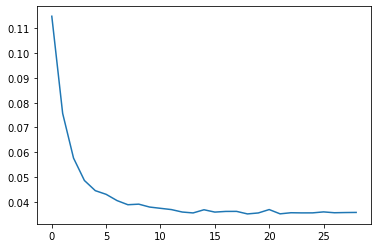

In [96]:
plt.plot(val_loss_list)

In [97]:
model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

In [98]:
val_loss = 0.0
for x_val, y_val in val_loader:
    x_val, y_val = torch.tensor(x_val).float(), torch.tensor(y_val).float()
    #if(x_val.shape[0]==batch_size):
    model.batch_size = x_val.shape[0]
    y_pred = model(x_val)
    val_loss += mae(y_pred, y_val).data.numpy()*x_val.shape[0]
val_loss /= (len(validation_dataset))

C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [99]:
val_loss

0.0350625025631858